# Names 
Spencer Bernardo-Cheng
Max Goldstein
Robbie Keehan

# Data Preparation

In [147]:
import numpy as np
import pandas as pd
datafb = pd.read_csv("./FB.csv")
datagoogle = pd.read_csv("./GOOGL.csv")
datamsft = pd.read_csv("./MSFT.csv")
dataam = pd.read_csv("./AMZN (1).csv")
datanflx = pd.read_csv("./NFLX.csv")

del datafb['Date']
del datagoogle['Date']
del datamsft['Date']
del datanflx['Date']


data = pd.concat([datafb, datagoogle, datamsft,datanflx, dataam ], axis=1, sort=False)
data = data[89:]
del data['Change']
del data['Gain']
del data['Loss']
del data['Average Gain']
del data['Average Loss']
del data['RS']
del data['DM+1']
del data['DM-1']
del data['TR-14']
del data['DM+1-14']
del data['DM-1+14']
del data['dl+1-14']
del data['dl-1-14']
del data['dl14diff']
del data['dl14sum']
del data['DX']
del data['TR']
ogdates = []
for val in data['Date']:
    ogdates.append(val)
del data['Date']

predictedDays = 14
up = .03
down =-.03
## Time difference the data
colheaders = data.columns[0:-3]
og = []
for val in data['Close-amzn']:
    og.append(val)
for header in colheaders: 
    for i in range(1, len(data)):
        perchange =((data[header].iloc[i]) - (data[header].iloc[i - 1]))/float(data[header].iloc[i-1])
        data.set_value(89+i,"pc-"+header,perchange)
#         data["pc"+header].at[90+i]= perchange
data = data[1:]
ydata= ydata[1:]
ydata = data['pc-Close-amzn']
# ydata = ydata.apply(lambda x:2 if x>=up else (1 if (x< up and x > down) else 0))
ydata = pd.DataFrame(ydata)
ydata['newy'] = ""
# created target data in format to match output of multiple timesteps of 14 days ahead
# [0,1,2,3,4,5,6,7]
# [1,2,3,4,5,6,7,8]
for index, row in ydata.iterrows():
    temp = np.array(ydata['pc-Close-amzn'][index-90:index-90+predictedDays].values)
    ydata['newy'].at[index] = temp
    
# removed last 14 because their targets are not able to created
ydata = ydata[0:-(predictedDays-1)]
data = data[0:-(predictedDays-1)]

del ydata['pc-Close-amzn']

xdata =data[['RSI-14 Day', 'ADX',
       'pc-Open-fb', 'pc-High-fb', 'pc-Low-fb', 'pc-Close-fb',
       'pc-Adj Close-fb', 'pc-Volume-fb', 'pc-Open-googl', 'pc-High-googl',
       'pc-Low-googl', 'pc-Close-googl', 'pc-Adj Close-googl',
       'pc-Volume-googl', 'pc-Open-msft', 'pc-High-msft', 'pc-Low-msft',
       'pc-Close-msft', 'pc-Adj Close-msft', 'pc-Volume-msft', 'pc-Open-nflx',
       'pc-High-nflx', 'pc-Low-nflx', 'pc-Close-nflx', 'pc-Adj Close-nflx',
       'pc-Volume-nflx', 'pc-Open-amzn', 'pc-High-amzn', 'pc-Low-amzn',
       'pc-Close-amzn', 'pc-Adj Close-amzn', 'pc-Volume-amzn', 'pc-SMA-7',
       'pc-SMA-21', 'pc-SMA-90']]


data = data[0:-1]
xdata = xdata[0:-1]
ydata = ydata[0:-1]
# data = data.T


//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


      RSI-14 Day        ADX  pc-Open-fb  pc-High-fb  pc-Low-fb  pc-Close-fb  \
90     47.267575  16.420508   -0.000490   -0.009639  -0.009425    -0.008333   
91     41.102218  14.497504   -0.022560   -0.029684  -0.026039    -0.029165   
92     40.370801  13.151813   -0.002509    0.001003   0.008226     0.005601   
93     38.584645  12.713275   -0.006539   -0.008016  -0.006629    -0.011646   
94     41.320419  13.057054   -0.003544    0.004040   0.000513     0.000000   
...          ...        ...         ...         ...        ...          ...   
1873   48.562974  13.738852   -0.000368   -0.011750  -0.006115    -0.006445   
1874   50.465834  13.738689    0.000369    0.026199   0.006365     0.025632   
1875   43.649539  15.293906    0.024737    0.003281   0.015811    -0.006582   
1876   44.135976  13.924882   -0.009091   -0.008533  -0.006693    -0.000207   
1877   40.333553  15.356140    0.006894    0.006545   0.010081     0.010096   

      pc-Adj Close-fb  pc-Volume-fb  pc-Open-googl 

# One Hot Encoding The Target Data

In [141]:
from keras.utils.np_utils import to_categorical
print(ydata.head())
# ydata['newy'] = ydata['newy'].apply(lambda x: to_categorical(x,3))
print(ydata)

                                                 newy
90  [-0.03126685348001901, -0.023788658883803833, ...
91  [-0.023788658883803833, -0.0031430016910281716...
92  [-0.0031430016910281716, -0.007616083827630422...
93  [-0.007616083827630422, 0.00750945697512207, -...
94  [0.00750945697512207, -0.0009828446509949397, ...
                                                   newy
90    [-0.03126685348001901, -0.023788658883803833, ...
91    [-0.023788658883803833, -0.0031430016910281716...
92    [-0.0031430016910281716, -0.007616083827630422...
93    [-0.007616083827630422, 0.00750945697512207, -...
94    [0.00750945697512207, -0.0009828446509949397, ...
...                                                 ...
1873  [-0.007968049902658595, 0.0035842157954330814,...
1874  [0.0035842157954330814, -0.01399888357705284, ...
1875  [-0.01399888357705284, 0.000849913019005562, -...
1876  [0.000849913019005562, -0.008611641517542337, ...
1877  [-0.008611641517542337, 0.007496472572400493, ...

[17

# Min-Max Scaling the Time Series

In [142]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(xdata.iloc[:,:].values)
print(x_scaled)



[[0.35811382 0.15022488 0.40722014 ... 0.53721892 0.45230866 0.64160589]
 [0.26414926 0.12331708 0.35961381 ... 0.50635447 0.41867806 0.57327146]
 [0.25300192 0.10448737 0.40286589 ... 0.51153038 0.41312322 0.576277  ]
 ...
 [0.3029723  0.1344608  0.461637   ... 0.50352112 0.48231708 0.23750753]
 [0.31038595 0.1153046  0.38866776 ... 0.50862139 0.47320208 0.21748327]
 [0.25243424 0.13533161 0.42314792 ... 0.49730187 0.44639693 0.21806241]]


# Utilizing Time Series Generator

In [165]:
from keras.models import Sequential
from keras.layers import Dense
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, Lambda, Dropout,GRU
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 2
series = np.array(x_scaled)
target = np.array(ydata)
generator = TimeseriesGenerator(series, target, length=90, batch_size=1)
xtime = []
ytarget =[]
for i in range(len(generator)):
    x, y = generator[i]
#     print(y)
    xtime.append(x[0])
    ytarget.append(y[0][0])
xtime = np.array(xtime)
ytarget = np.array(ytarget)

target = target[90:]
print(target[0].shape)
print(xtime.shape)
print(target.shape)
print(ytarget.shape)

(1,)
(1698, 90, 35)
(1698, 1)
(1698, 14)


# Time Series Fold Splits

In [62]:
from sklearn.model_selection import train_test_split
import keras.utils
from keras import utils as np_utils
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
# for train_index, test_index in tscv.split(xtime,ytarget):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     x_train, x_test = xtime[train_index], xtime[test_index]
#     y_train, y_test = ytarget[train_index], ytarget[test_index]
    
    
    
x_train,x_test,y_train,y_test = train_test_split(xtime, ytarget, test_size = 1/4)

print(x_train.shape)
print(y_train.shape)
print(y_test.shape)

y_train = y_train.reshape(1273,14,1)
y_test= y_test.reshape(425,14,1)
print(y_test[0])



(1273, 90, 36)
(1273, 14)
(425, 14)
[[ 0.13610046]
 [-0.08900024]
 [-0.05549988]
 [-0.07190002]
 [ 0.0076001 ]
 [ 0.08039978]
 [ 0.13530029]
 [ 0.13009949]
 [-0.02349976]
 [-0.1297998 ]
 [ 0.02529968]
 [ 0.11669983]
 [-0.13569947]
 [ 0.12059998]]


# LSTM

In [17]:

model = Sequential()
model.add(LSTM(100,dropout=.2,activation='relu', input_shape=(90, 36), return_sequences=True))
model.add(Lambda(lambda x: x[:, -predictedDays:, :]))
model.add(Dense(1))

model.summary()
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=50, verbose=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 100)           54800     
_________________________________________________________________
lambda_1 (Lambda)            (None, 14, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 14, 1)             101       
Total params: 54,901
Trainable params: 54,901
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 1273 samples, validate on 425 samples
Epoch 1/50
1273/1273 [==============================] - 5s 4ms/step - loss: 0.0425 - val_loss: 0.0334
Epoch 2/50
1273/12

# LSTM Validation & Training Loss

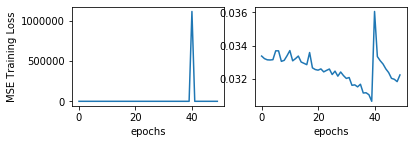

In [19]:
from matplotlib import pyplot as plt

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

# GRU

In [43]:
from keras.layers import LSTM, Lambda, Dropout,GRU

gru = Sequential()
gru.add(GRU(100,dropout=.2,activation='relu', input_shape=(90, 36), return_sequences=True))
gru.add(Lambda(lambda x: x[:, -predictedDays:, :]))
gru.add(Dense(1))

gru.summary()
gru.compile(optimizer='adam', loss='mse')

# fit model
history = gru.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 90, 100)           41100     
_________________________________________________________________
lambda_7 (Lambda)            (None, 14, 100)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 14, 1)             101       
Total params: 41,201
Trainable params: 41,201
Non-trainable params: 0
_________________________________________________________________
Train on 1273 samples, validate on 425 samples
Epoch 1/300
1273/1273 [==============================] - 4s 3ms/step - loss: 0.0452 - val_loss: 0.0357
Epoch 2/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0375 - val_loss: 0.0334
Epoch 3/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0368 - val_loss: 0.0330
Epoch 4/300
1273/1273 [=======================

1273/1273 [==============================] - 3s 2ms/step - loss: 0.0171 - val_loss: 0.0141
Epoch 73/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0171 - val_loss: 0.0145
Epoch 74/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0172 - val_loss: 0.0137
Epoch 75/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0168 - val_loss: 0.0141
Epoch 76/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0166 - val_loss: 0.0136
Epoch 77/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0164 - val_loss: 0.0145
Epoch 78/300
1273/1273 [==============================] - 3s 3ms/step - loss: 0.0159 - val_loss: 0.0131
Epoch 79/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0163 - val_loss: 0.0138
Epoch 80/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0158 - val_loss: 0.0133
Epoch 81/300
1273/1273 [==============================] - 3s 2ms/step - loss:

1273/1273 [==============================] - 3s 2ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 151/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 152/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 153/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 154/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 155/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 156/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 157/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 158/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 159/300
1273/1273 [==============================] - 3s 2ms/ste

1273/1273 [==============================] - 3s 2ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 229/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 230/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 231/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 232/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 233/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 234/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 235/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 236/300
1273/1273 [==============================] - 3s 2ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 237/300
1273/1273 [==============================] - 3s 2ms/ste

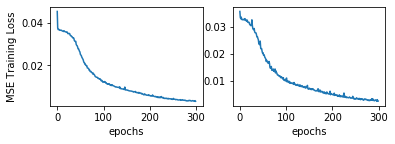

In [47]:
from matplotlib import pyplot as plt

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

# Stacked RNN

In [48]:

modelstacked = Sequential()
modelstacked.add(GRU(100,dropout=.2,recurrent_dropout=.2,activation='relu', input_shape=(90, 36), return_sequences=True))
modelstacked.add(GRU(100,dropout=.4,activation='relu', return_sequences=True))

modelstacked.add(Lambda(lambda x: x[:, -predictedDays:, :]))

modelstacked.add(Dense(1))

modelstacked.summary()
modelstacked.compile(optimizer='adam', loss='mse')

# fit model
historystacked = modelstacked.fit(x_train, y_train, validation_data=(x_test,y_test),epochs=300, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 90, 100)           41100     
_________________________________________________________________
gru_10 (GRU)                 (None, 90, 100)           60300     
_________________________________________________________________
lambda_8 (Lambda)            (None, 14, 100)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 14, 1)             101       
Total params: 101,501
Trainable params: 101,501
Non-trainable params: 0
_________________________________________________________________
Train on 1273 samples, validate on 425 samples
Epoch 1/300
1273/1273 [==============================] - 9s 7ms/step - loss: 0.0403 - val_loss: 0.0340
Epoch 2/300
1273/1273 [==============================] - 6s 5ms/step - loss: 0.0371 - val_loss: 0.0336
Epoch 3/300
127

KeyboardInterrupt: 

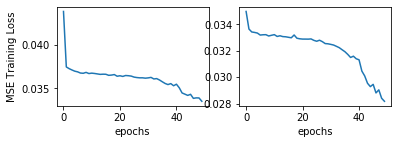

In [25]:
from matplotlib import pyplot as plt

plt.subplot(2,2,3)
plt.plot(historystacked.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(historystacked.history['val_loss'])
plt.xlabel('epochs')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
#From Sklearn documentation 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = list(unique_labels(y_true, y_pred))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Backtracing GRU Prediction vs Real

[ 0.18198265 -0.13755724 -0.05083889 -0.15583575 -0.02333391  0.04399718
  0.03793976  0.01414156  0.0340714  -0.08442812 -0.02343939  0.03826041
 -0.06522281  0.06323767]
[ 0.13610046 -0.08900024 -0.05549988 -0.07190002  0.0076001   0.08039978
  0.13530029  0.13009949 -0.02349976 -0.1297998   0.02529968  0.11669983
 -0.13569947  0.12059998]
[993.9799800000001, 976.7800289999999, 990.330017, 975.929993, 968.0, 953.659973, 971.400024, 965.1400150000001, 978.76001, 996.4699710000001, 994.1300050000001, 1006.51001, 1000.6300050000001, 1001.8099980000001, 1010.0399779999999, 1024.449951, 1026.869995, 1028.699951, 1025.670044, 1038.949951, 1039.869995, 1052.800049, 1046.0, 1020.0399779999999, 987.7800289999999, 996.1900019999999, 995.8900150000001, 986.919983, 987.580017, 992.2700199999999, 989.840027, 982.01001, 956.919983, 967.98999, 983.2999880000001, 982.73999, 978.179993, 960.570007, 958.4699710000001, 953.2899779999999, 966.900024, 958.0, 952.4500119999999, 945.26001, 946.020019999999

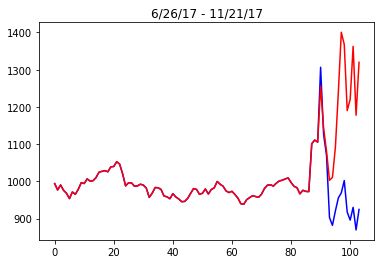

In [68]:
base = 1274
yhat = gru.predict(x_test[0][np.newaxis,:,:])
print(yhat[0].ravel())
print(y_test[0].ravel())
print(og[base-90:base+14])
# print(yhat[0] - y_test[0])
backtesting = og[base-90:base]
yhatBack=og[base-1]
ytestBack = og[base-1]
ytest_backtesting=og[base-90:base]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90],ogdates[base+14]))

plt.show()




[ 0.04330329  0.0502106   0.03220146  0.02166118  0.03041862  0.0180639
  0.0313208   0.0380958   0.04391285  0.04543603  0.04858357  0.03485228
  0.00942533 -0.01149075]
[ 0.34399994  0.17600006 -0.00359985 -0.05119995 -0.16350006  0.14009979
 -0.05829987 -0.05720001  0.18539978 -0.00649963  0.05349975  0.07200012
 -0.08059997  0.0098999 ]
104


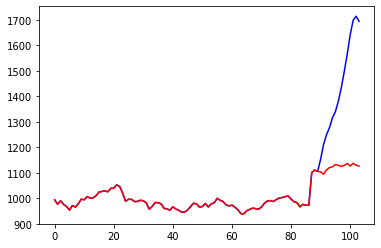

In [50]:
base = 1274
yhat = model.predict(x_test[0][np.newaxis,:,:])
print(yhat[0].ravel())
print(y_test[0].ravel())
print(og[base-90:base+14])
# print(yhat[0] - y_test[0])
backtesting = og[base-90:base]
yhatBack=og[base-1]
ytestBack = og[base-1]
ytest_backtesting=og[base-90:base]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90],ogdates[base+14]))

plt.show()


[ 0.0220135   0.01218393  0.01179546  0.00977245  0.01511652  0.00954321
  0.02040801  0.01258576  0.02113073  0.01977534  0.02143903  0.0137038
 -0.01153574  0.02437728]
[ 0.34399994  0.17600006 -0.00359985 -0.05119995 -0.16350006  0.14009979
 -0.05829987 -0.05720001  0.18539978 -0.00649963  0.05349975  0.07200012
 -0.08059997  0.0098999 ]
104


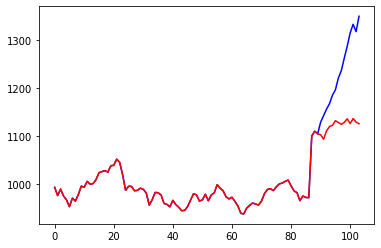

In [45]:
base = 1274
yhat = modelstacked.predict(x_test[0][np.newaxis,:,:])
print(yhat[0].ravel())
print(y_test[0].ravel())
print(og[base-90:base+14])
# print(yhat[0] - y_test[0])
backtesting = og[base-90:base]
yhatBack=og[base-1]
ytestBack = og[base-1]
ytest_backtesting=og[base-90:base]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90],ogdates[base+14]))

plt.show()


In [ ]:
pred = model.predict(x_test[243][np.newaxis,:,:])
print(x_test[0].shape)
print(x_test.shape)

print(pred)
